## Importando dados de fragmentação (MS/MS)

A biblioteca _matchms_ pode importar dados de MS/MS em vários formatos, como .mzml, .mzxml ou arquivos .mgf no estilo GNPS. Outra opção seria usar o Identificador Universal de Espectro para espectros de massa [_Universal Spectrum Identifier for mass spectra_](https://www.biorxiv.org/content/10.1101/2020.12.07.415539v1.full).
Vamos começar com alguns espectros do GNPS em formato de arquivo .mgf que podem ser obtidos [aqui](https://external.gnps2.org/gnpslibrary). Para o exemplo a seguir, baixamos esta biblioteca de espectros.

In [ ]:
!pip install matchms spec2vec

In [13]:
import os
from matchms.importing import load_from_json

spectra = list(load_from_json("GNPS-NIH- NATURALPRODUCTSLIBRARY_processed.json"))

Cada um desses objetos contém os metadados do espectro `spectrum.metadata` e os picos do espectro `spectrum.peaks` com `spectrum.peaks.mz` e `spectrum.peaks.intensities`.

## Spec2Vec: uma ferramenta de aprendizado de máquina para avaliar similaridades de espectrais

Spec2Vec é uma técnica de aprendizado de máquina não supervisionada que pode aprender relações entre picos a partir de coocorrências em grandes conjuntos de dados MS/MS. Baseia-se principalmente no algoritmo Word2Vec, bem conhecido na área de processamento de linguagem natural.

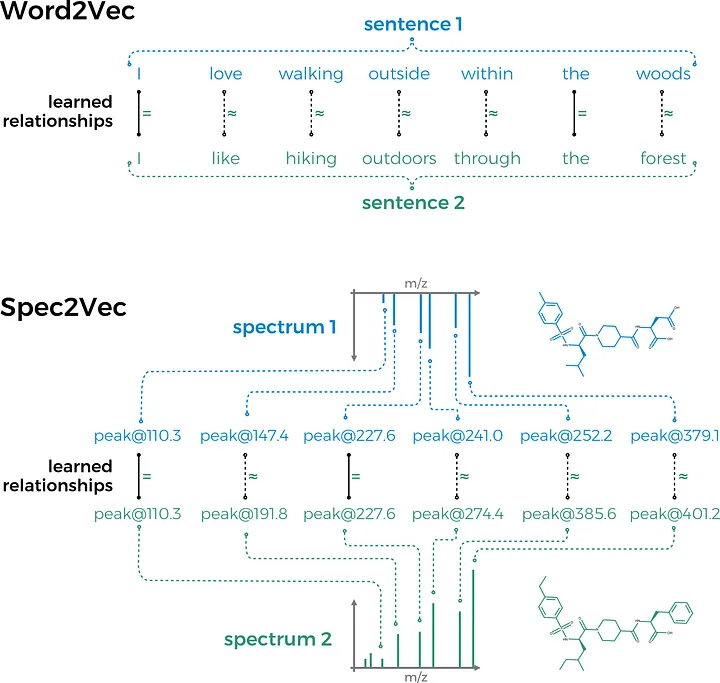

In [46]:
!wget https://zenodo.org/records/4173596/files/spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model

--2025-09-16 12:06:44--  https://zenodo.org/records/4173596/files/spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7864010 (7.5M) [application/octet-stream]
Saving to: ‘spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model’

spec2vec_AllPositiv 100%[===================>]   7.50M   606KB/s    in 9.4s    

2025-09-16 12:06:55 (821 KB/s) - ‘spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model’ saved [7864010/7864010]



In [5]:
!wget https://zenodo.org/records/4173596/files/spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy

--2025-09-16 13:02:41--  https://zenodo.org/records/4173596/files/spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139092128 (133M) [application/octet-stream]
Saving to: ‘spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy’

spec2vec_AllPositiv 100%[===================>] 132.65M  1.26MB/s    in 2m 16s  

2025-09-16 13:05:00 (997 KB/s) - ‘spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy’ saved [139092128/139092128]



In [7]:
!wget https://zenodo.org/records/4173596/files/spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy

--2025-09-16 13:08:59--  https://zenodo.org/records/4173596/files/spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139092128 (133M) [application/octet-stream]
Saving to: ‘spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy’

spec2vec_AllPositiv 100%[===================>] 132.65M   906KB/s    in 2m 18s  

2025-09-16 13:11:18 (984 KB/s) - ‘spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy’ saved [139092128/139092128]



In [8]:
# pip install scipy==1.10.1
import gensim

filename_model = "spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model"

model = gensim.models.Word2Vec.load(filename_model)

In [9]:
model.wv.index_to_key[0]

'peak@105.07'

Calcular similaridades entre espectros

In [10]:
from spec2vec import Spec2Vec

spec2vec_similarity = Spec2Vec(model=model,
                               intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

Além de usar o modelo carregado anteriormente, definimos aqui dois parâmetros. O próprio `model` converterá picos de espectro (aqui: "palavras") em vetores abstratos ("embeddings"), que são então somados para nos fornecer um _embedding_ de espectro.

In [16]:
%%timeit

from matchms import calculate_scores

scores = calculate_scores(spectra, spectra, spec2vec_similarity,
                          is_symmetric=True)

531 ms ± 7.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
best_matches = scores.scores_by_query(spectra[11], sort=True)[:10]

[x[1] for x in best_matches]

[0.9999999999999997,
 0.6323327469158129,
 0.6094968210816908,
 0.5633651650965527,
 0.532211381301199,
 0.5311480111999451,
 0.4945567510974197,
 0.48921947174118857,
 0.46979465313015445,
 0.4092511656226544]

# Calcular rede/grafo a partir de similaridades

Grafos baseados em similaridades podem ser gerados (e filtrados/modificados) de diversas maneiras. A função `create_network()` criará um nó para cada espectro. Em seguida, adicionará arestas (conexões) para cada nó da seguinte maneira: para cada espectro, serão adicionadas as conexões com maior pontuação `max_links`, desde que tenham uma pontuação de _similaridade > cutoff_. Isso significa que, por nó, entre 0 (se não houver uma pontuação de similaridade alta o suficiente) e `max_links` conexões serão adicionadas.

In [19]:
import networkx as nx
import matchmsextras.networking as net
from matchms.networking import SimilarityNetwork

ms_network = SimilarityNetwork(identifier_key="spectrum_id",
                               score_cutoff=0.7,
                               max_links=10)
ms_network.create_network(scores)
our_network = ms_network.graph

In [21]:
our_network

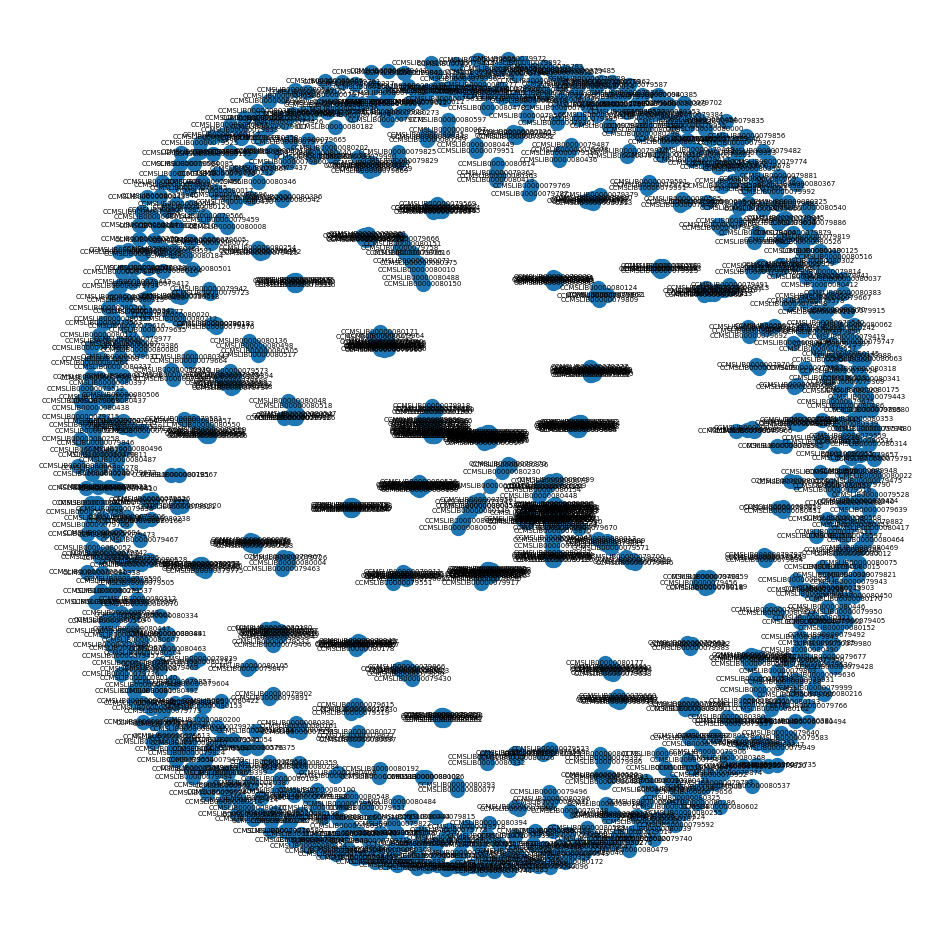

In [20]:
net.plot_cluster(our_network)

In [25]:
from pyvis.network import Network

In [35]:
nt = Network('500px', '500px', notebook=True, cdn_resources='in_line')
nt.from_nx(our_network)
nt.show('nx.html')

nx.html


Visualizar componentes da rede

In [30]:
subnetworks = [our_network.subgraph(c).copy() for c in nx.connected_components(our_network)]

In [31]:
clusters = {}
for i, subnet in enumerate(subnetworks):
    if len(subnet.nodes) > 2: # exclude clusters with <=2 nodes
        clusters[i] = len(subnet.nodes)
        
clusters

{0: 59,
 1: 10,
 7: 28,
 9: 7,
 10: 3,
 12: 11,
 15: 8,
 16: 17,
 17: 32,
 18: 8,
 19: 8,
 21: 10,
 25: 10,
 26: 15,
 28: 4,
 29: 11,
 35: 10,
 36: 3,
 38: 4,
 42: 11,
 44: 11,
 46: 7,
 47: 7,
 49: 3,
 53: 18,
 54: 8,
 65: 10,
 67: 8,
 68: 20,
 71: 3,
 72: 5,
 75: 4,
 76: 7,
 82: 6,
 83: 4,
 95: 4,
 96: 4,
 102: 18,
 103: 3,
 112: 3,
 117: 4,
 121: 4,
 129: 3,
 132: 4,
 133: 5,
 150: 3,
 153: 3,
 163: 4,
 167: 4,
 168: 7,
 176: 4,
 177: 10,
 205: 6,
 222: 3,
 226: 10,
 233: 4,
 234: 4,
 237: 7,
 239: 3,
 250: 3,
 252: 3,
 256: 4,
 258: 3,
 261: 10,
 270: 5,
 274: 3,
 298: 4,
 357: 3,
 441: 4,
 495: 3,
 543: 3}

In [36]:
subnetworks[19]

In [32]:
net.plot_cluster(subnetworks[19])

KeyError: 'weight'

Exportar o grafo para ser visualizado por outro _software_ como o [Cytoscape](https://cytoscape.org/).

In [34]:
# export the graph
nx.write_graphml(our_network, "network_GNPS_cutoff_07.graphml")

# collect the metadata
metadata = net.extract_networking_metadata(spectra)
metadata.head()# export the metadata
metadata.to_csv("network_GNPS_metadata.csv")